# fastMRI Data Processing

## Introduction
This notebook shows how to read the fastMRI dataset and apply some simple transformations to the data.

First, we import some necessary libs:

In [1]:
%matplotlib inline

import os
import h5py
import numpy as np
from matplotlib import pyplot as plt

## Data Description

The fastMRI dataset is distributed as a set of `HDF5` files and can be read with the `h5py` package. The `HDF5` files share the following common attributes:

- ***acquisition***: Acquisition protocol.
	- Knee: `CORPD` or `CORPDF`
	- Brain: `AXFLAIR`, `AXT1`, `AXT1POST` or `AXT2`
- ***patient_id***: A unique string identifying the examination
- ***norm, max***: The Euclidean norm and the largest entry of the target volume.
	- *single*: the target volume is stored in `reconstruction esc`
	- *multi*: the target volume is stored in `reconstruction rss`
- **acceleration**: Acceleration factor of the undersampled k-space trajectory (either 4 or 8). Only available in the test dataset.
- **num low frequency**: The number of low-frequency k-space lines in the undersampled k-space trajectory. This attribute is *only available in the test dataset*.

Since we have not download the multi-coil dataset, here we show how to open a file from the single-coil dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some metadata related to the scan. For a single-coil `h5` file, it contains:

- *knee singlecoil train*: Training dataset for the single-coil track.
	- ***kspace***: Emulated single-coil k-space data. The shape of the kspace tensor is `(number of slices, height, width)``.
	- ***reconstruction_rss***: root-sum-of-squares reconstruction of the multi-coil k-space that was used to derive the emulated single-coil k-space cropped to the centre$320 \times 320$ region. The shape of the reconstruction rss tensor is `(number of slices, 320, 320)`.
	- ***reconstruction_esc***: The inverse Fourier transform of the single-coil k-space data cropped to the centre $320 \times 320$ region. The shape of the reconstruction esc tensor is `(number of slices, 320, 320)`.
	- ***ismrmrd_header***: The XML header from the `ISMRMRD` file that was used to generate the `HDF5` file

In [2]:
# Storage Location
DATA = 'Dataset'
PARTITION = 'singlecoil_val'
# Partition = 'Train'
file_name = 'file1000263.h5'
hf = h5py.File(os.path.join(DATA, PARTITION, file_name))
print('Keys: ', list(hf.keys()))
print('Attributes: ', list(hf.attrs))

Keys:  ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
Attributes:  ['acquisition', 'max', 'norm', 'patient_id']


MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [3]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(35, 640, 454)


Let's see what the absolute value of k-space looks like:

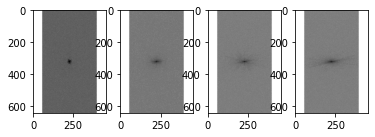

In [4]:
# Choosing the 20-th slice of this volume
slice_kspace = volume_kspace

def show_coils(data, slice_nums, cmap=None):
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i+1)
        plt.imshow(data[num], cmap=cmap)
        
show_coils(np.log(np.abs(slice_kspace) +1e-9), [0, 10, 20, 31], cmap='Greys')

The fastMRI repo contains some utility functions to convert k-space into image space. These functions work on PyTorch Tensors. The `to_tensor` function can convert Numpy arrays to PyTorch Tensors.

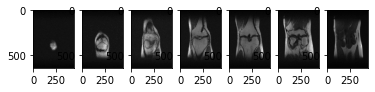

In [5]:
import fastmri
from fastmri.data import transforms as T

# Convert from numpy array to pytorch tensor
slice_kspace2 = T.to_tensor(slice_kspace)
# Apply Inverse Fourier Transform to get the complex image
slice_image = fastmri.ifft2c(slice_kspace2)
slice_image_abs = fastmri.complex_abs(slice_image)


show_coils(slice_image_abs, [0, 5, 10, 15, 20, 25, 31], cmap='Greys_r')

In [6]:
from skimage.io import imsave

imsave('31.png',(slice_image_abs[31] - slice_image_abs[31].min())/slice_image_abs[31].max() * 255)

Lossy conversion from float32 to uint8. Range [0.0, 254.9939422607422]. Convert image to uint8 prior to saving to suppress this warning.


As we can see, each slice shows a part of knee.

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.

In [10]:
from fastmri.data.subsample import RandomMaskFunc

# Create the mask function object
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])
# Apply the mask to k-space
masked_kspace, mask, _ = T.apply_mask(slice_kspace2, mask_func)

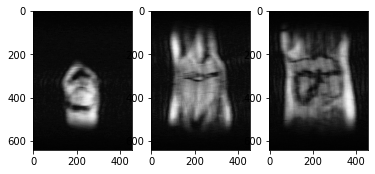

In [11]:
# Apply Inverse Fourier Transform to get the complex image
sampled_image = fastmri.ifft2c(masked_kspace)           
# Compute absolute value to get a real image
sampled_image_abs = fastmri.complex_abs(sampled_image)   

fig = plt.figure()
show_coils(sampled_image_abs, [5, 15, 25], cmap='Greys_r')

## Reference

- [Paper](https://arxiv.org/abs/1811.08839)
- [Paper notes](https://wiki.rasin.cyou/#/MRI/Dataset/fastMRI)